
sources :
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- deeplearningwizard for model architecture

In [1]:
%pwd

'/Users/Maxine/Desktop/se_corpus/rubrix'

In [ ]:
# installations for colab
!pip install skorch
!pip install modal

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import rubrix as rb
import webbrowser

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


## 1) Data

In [3]:
"""
load data: specify path
"""

# 1) (index), text, label
initial_train = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # macbook
# initial_train = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) #imac
# initial_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
initial_train.drop(columns=['text'], inplace = True)

dev = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-dev.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
# dev = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-dev.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
# dev = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-dev.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)

test = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
# test = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
# test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/es_ancora-ud-test.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

# by fileting out 'se'-sentences the data split of the initial ud corpus isn't accurate anymore
se_corpus = pd.concat([initial_train, dev, test])

pool = pd.read_csv('/Users/Maxine/Desktop/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # macbook
# pool = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # imac
# pool = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/master/sp_text_se_corpus.txt', names=['text'], sep='\t')

# Note: for some reason jupyter cannot find the relative path

In [4]:
"""
drop labels that appear only once
"""
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'flat')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'fixed')].index)
se_corpus.shape

(4248, 2)

In [6]:
"""
data split
"""
X = se_corpus.tokenized_text
y = se_corpus.se_label

# Split into train+val and test
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train and val
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, stratify=y, random_state=21)

In [7]:
"""
check label distribution in splits
"""
def get_class_dist(df_col):
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')


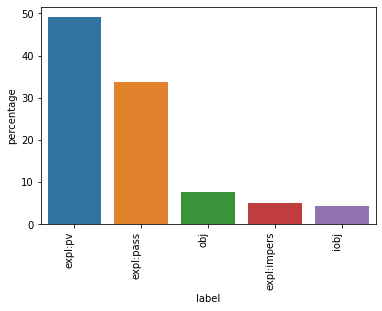

In [7]:
get_class_dist(y_train)

In [8]:
"""
store value counts for making weighted data sets
"""
y_train_counter = dict(y_train.value_counts())

In [9]:
"""
eventually implement fasttext word embeddings instead of CountVectorizer()
"""
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # todo change to es
# ft = fasttext.load_model('cc.en.300.bin') # rename model

'\neventually implement fasttext word embeddings instead of CountVectorizer()\n'

In [10]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_dev = vectorizer.transform(X_dev).toarray()
X_test = vectorizer.transform(X_test).toarray()

pool_vectorized = vectorizer.transform(pool.text).toarray()

y_train = label_encoder.fit_transform(y_train)
y_dev = label_encoder.transform(y_dev)
y_test = label_encoder.transform(y_test)


In [11]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


In [12]:
class PoolDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [13]:
"""
convert data splits into Datasets
"""
train_set = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
dev_set = ClassifierDataset(torch.from_numpy(X_dev).float(), torch.from_numpy(y_dev).long())
test_set = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

pool_set = PoolDataset(torch.from_numpy(pool_vectorized).float())

In [14]:
"""
assign bigger weight to less frequent labels
"""
target_list = torch.tensor([target for _, target in train_set])
class_count = [label for label in y_train_counter.values()]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
print('label distribution: ', y_train_counter.items(), '\nassigned weights: ', class_weight)

label distribution:  dict_items([('expl:pv', 1502), ('expl:pass', 1032), ('obj', 232), ('expl:impers', 157), ('iobj', 135)]) 
assigned weights:  tensor([0.0007, 0.0010, 0.0043, 0.0064, 0.0074])


In [15]:
"""
assign weight to each sample in the train set
"""
class_weight_all = class_weight[target_list]
weighted_sampler = WeightedRandomSampler(weights=class_weight_all, num_samples=len(class_weight_all), replacement=True)

In [16]:
"""
convert Datasets into weighted DataLoader objects
"""
train_loader = DataLoader(dataset=train_set, batch_size=64, sampler=weighted_sampler)
dev_loader = DataLoader(dataset=dev_set, batch_size=32)
test_loader = DataLoader(dataset=test_set, batch_size=32)

## 2) Model

In [17]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super(LSTMModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = 64

        # Number of hidden layers
        self.layer_dim = 1

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(16325, 64, 1, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(64, 5)

    def forward(self, x):
        # Initialize hidden state with zeros
        #######################
        #  USE GPU FOR MODEL  #
        #######################
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # One time step
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [18]:
"""
skorch library creates sklearn classifier from torch neural net
"""
batch_size = 64
n_iters = 1000 ### todo gpu
epochs = int(n_iters/(len(train_set)/ batch_size))

# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using: ', device)

# Callbacks: print accuracy when model is fitted
train_acc = EpochScoring(scoring='accuracy', on_train=True,
                         name='train_acc', lower_is_better=False)
callbacks = [train_acc]

classifier = NeuralNetClassifier(module=LSTMModel,
                                 batch_size=64,
                                 max_epochs= epochs,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.SGD,
                                 lr=0.1,
                                 train_split=None,
                                 callbacks=callbacks,
                                 verbose=1,
                                 device=device)

using:  cpu


In [19]:
"""
LSTM need 3-D input: determine shape and reshape
- train
- pool
"""
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 16325])
Labels batch shape: torch.Size([64])


In [20]:
#reshaping to rows, timestamps, features
train_features = torch.reshape(train_features,   (train_features.shape[0], 1,train_features.shape[1]))
print(f"Feature batch shape: {train_features.size()}")

Feature batch shape: torch.Size([64, 1, 16325])


In [21]:
# do the same for the test data which is going to be used in the active learning loop
test_features, test_labels = next(iter(test_loader))
test_features = torch.reshape(test_features,   (test_features.shape[0], 1,test_features.shape[1]))

In [22]:
# do the same for the data pool which is going to be used in the active learning loop
X_pool = pool_set.X_data
X_pool = torch.reshape(X_pool,   (X_pool.shape[0], 1, X_pool.shape[1]))
X_pool = X_pool.detach().cpu().numpy()

In [23]:
"""
fit the skorch classifier with the training data instead of leaving fitting to the ActiveLearner() (which would expect different shapes for the input data, would be incompatible with LSTM)
"""
classifier.fit(train_features, train_labels)

  epoch    train_acc    train_loss     dur
-------  -----------  ------------  ------
      1       0.0312        1.6198  0.0331
      2       0.3125        1.5885  0.0278
      3       0.5625        1.5591  0.0221
      4       0.6094        1.5314  0.0210
      5       0.6094        1.5054  0.0230
      6       0.6094        1.4810  0.0216
      7       0.6094        1.4581  0.0237
      8       0.6094        1.4366  0.0213
      9       0.6094        1.4164  0.0226
     10       0.6094        1.3976  0.0215
     11       0.6094        1.3800  0.0214
     12       0.6094        1.3635  0.0218
     13       0.6094        1.3481  0.0235
     14       0.6094        1.3338  0.0208
     15       0.6094        1.3204  0.0235
     16       0.6094        1.3079  0.0216
     17       0.6094        1.2963  0.0224
     18       0.6094        1.2855  0.0223
     19       0.6094        1.2755  0.0226
     20       0.6094        1.2661  0.0233


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(16325, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=5, bias=True)
  ),
)

## 3) Active Learner

In [1]:
type(classifier)

NameError: name 'classifier' is not defined

In [24]:
"""
Initialize the ActiveLearner with the fitted classifier
"""
learner = ActiveLearner(estimator=classifier,
                        query_strategy=uncertainty_sampling
)

In [25]:
n_instances = 10
accuracies = []

### Loop
- stops after 20 iterations
- opens the rubrix web interface
- waits for user response

Problem: if annotation is None (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no suited programmatical way to differentiate btw. 'pase' and 'siéntese'.

In [26]:
while len(accuracies) < 1:
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    probabilities = learner.predict_proba(X_pool[query_idx])
    records = [
        rb.TextClassificationRecord(
            id=idx,
            inputs=pool.text.iloc[idx],
            prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
            prediction_agent="skorch_classifier",
        )
        for idx, probs in zip(query_idx, probabilities)
    ]

    # log the records
    rb.log(records, name="pytorch_active_learning_se_corpus")
    webbrowser.get('firefox').open_new_tab('http://0.0.0.0:6900')

    input('confirm that annotations on rubrix are done')
    records_df = rb.load("pytorch_active_learning_se_corpus", ids=query_idx.tolist(), as_pandas=False)
    annotation = [record.annotation for record in records_df]
    if None in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample is None]
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter(None.__ne__, annotation))

    # train the classifier with the newly annotated examples
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool, only_new=True)
    accuracies.append(learner.score(X=test_features, y=test_labels))

    X_pool = np.delete(X_pool, query_idx, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/pytorch_active_learning_se_corpus
confirm that annotations on rubrix are done


2022-04-06 17:13:40.686 | WARNING  | rubrix.client.rubrix_client:load:310 - The argument 'as_pandas' in `rb.load` will be deprecated in the future, and we will always return a `Dataset`. To emulate the future behavior set `as_pandas=False`. To get a pandas DataFrame, call `Dataset.to_pandas()`


Note: you either discarded samples or did not annotate all samples
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_acc    train_loss     dur
-------  -----------  ------------  ------
      1       0.1111        1.6212  0.0151
      2       0.2222        1.5928  0.0186
      3       0.5556        1.5656  0.0125
      4       0.6667        1.5395  0.0120
      5       0.6667        1.5146  0.0146
      6       0.5556        1.4907  0.0124
      7       0.5556        1.4678  0.0153
      8       0.5556        1.4459  0.0145
      9       0.5556        1.4249  0.0137
     10       0.5556        1.4047  0.0132
     11       0.5556        1.3854  0.0133
     12       0.5556        1.3668  0.0139
     13       0.5556        1.3489  0.0160
     14       0.5556        1.3317  0.0138
     15       0.5556        1.3151  0.0140
     16       0.5556        1.2991  0.0128
     17       0.5556        1.2837  0.0136
     18       0.5556        1.2688  0.

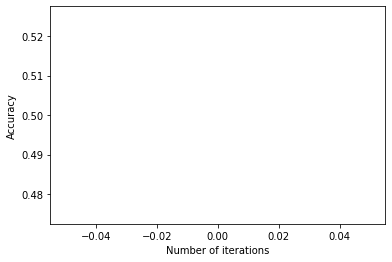

In [27]:
# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");

In [28]:
max(accuracies)

0.5

In [ ]:
"""
save the samples and the annotations
"""
dataset_rb = rb.load("sklearn_active_learning_se_corpus", as_pandas=True)
dataset_rb.to_csv('sklearn_annotations.txt')